# Solving Linear Systems
This follows the notes in https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf

## 1. Using Gradient Descent

Assume our linear system is given by $$A x = b$$

To solve it using gradient descent, we can first transform the system into its **quadratic form**: $$ f(x) = \frac{1}{2} x^T A x - x^T b $$

The gradient of $f(x)$ is: $$ \nabla f (x) = \frac{1}{2} (A^T + A) x - b $$

When $A$ is symetric, then the gradient is $$ \nabla f(x) = Ax - b $$ and this gradient is zero when $Ax = b$. Meaning that minimizing $f(x)$, is equivalent to solving the linear system.

An optimal step size can be computed analytically as: $$ \alpha = \frac{\nabla f^T \nabla f}{\nabla f^T A \nabla f} $$

In [1]:
import numpy as np

A = np.array([
    [3., 2.],
    [2., 6.],
])

b = np.array([2., -8.])

solution = np.linalg.solve(A, b)
print("Solution is:", solution)

Solution is: [ 2. -2.]


In [2]:
def is_pd(matrix) -> bool:
    es = np.linalg.eigvals(A)
    print("eigenvalues:", es)
    return es.min() >= 0.0

assert is_pd(A)

eigenvalues: [2. 7.]


In [3]:
A @ solution - b

array([0., 0.])

In [4]:
import matplotlib.pyplot as plt

In [5]:
def f(x):
    return 0.5 * (x.T @ A @ x) - (x @ b)

def grad_f(x):
    return A @ x - b

def opt_alpha(grad):
    return grad.T @ grad / (grad.T @ A @ grad)

f(solution)

np.float64(-10.0)

Plot the landscape of $f(x)$:

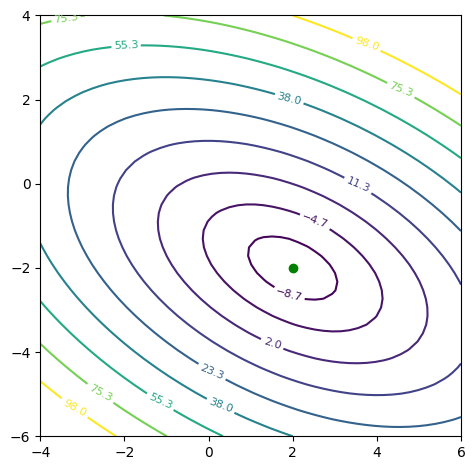

In [6]:
def plot_loss():
    x1s = np.linspace(-4, 6)
    x2s = np.linspace(-6, 4)
    X1, X2 = np.meshgrid(x1s, x2s)
    Z = np.array([f(pair) for pair in np.array([X1.flatten(), X2.flatten()]).T]).T.reshape(X1.shape)
    
    fig, ax = plt.subplots()
    CS = ax.contour(X1, X2, Z, levels=[f(np.array([solution[0], y])) for y in np.linspace(solution[1], 4, 10)])
    ax.scatter(*solution, color="green")
    ax.clabel(CS, inline=True, fontsize=8)
    fig.tight_layout()
    ax.set_aspect("equal", "box")
    return fig

plot_loss()
plt.show()

### Find the solution with minimization

In [7]:
worst_case = np.array([-3, 3])
x = worst_case
xs = [x]
grads = []
for _ in range(10):
    grad = grad_f(x)
    grads.append(grad)
    alpha = opt_alpha(grad=grad)
    x = x - alpha * grad
    xs.append(x)
    print("loss:", f(x))
xs = np.array(xs)
grads = np.array(grads)

loss: 8.975903614457831
loss: -4.2386413122369015
loss: -8.250768205643011
loss: -9.468907937134986
loss: -9.838752771274718
loss: -9.951043010073768
loss: -9.985135950046494
loss: -9.995487059532188
loss: -9.998629806026642
loss: -9.999583989299655


### Display & Evaluate
Even though the optimization is moving towards the solution, it is no progressing quickly, probably because the gradient is vanishing. 

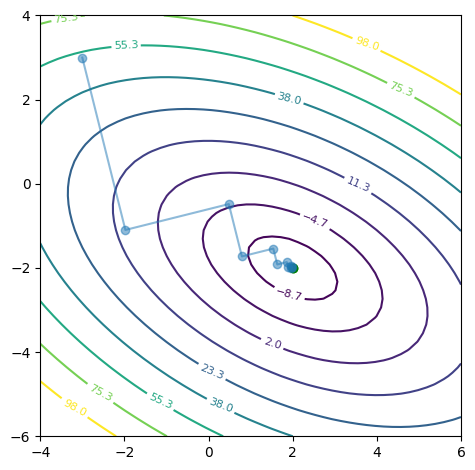

In [8]:
plot_loss()
plt.plot(*xs.T, marker="o", alpha=0.5)
plt.scatter(*solution, color="green")
plt.show()

Text(0.5, 1.0, 'Weak Gradients')

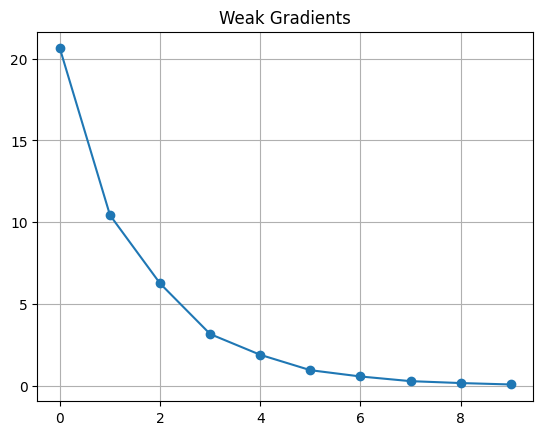

In [9]:
grad_norms = np.linalg.norm(grads, axis=1)

plt.plot(grad_norms, marker="o")
plt.grid()
plt.title("Weak Gradients")

In [10]:
del x

# 2. Using Conjugate Gradients (CG)
CG starts with the gradient as the first direction of optimization, and then uses only "conjugate" directions to supplement the optimization. Two directions $p_1$ and $p_2$ are conjugate if $$ p_1^T A p_2 = 0 $$

This is the same as an inner product over $A$: $$ \langle p_1, p_2 \rangle_A $$

To find conjugate directions, we use a Gram-Schimdt orthonormalization.

In [11]:
x0 = np.zeros_like(solution)

In [12]:
def r(x):
    return b - A @ x

def p(r, ps):
    print(f"substracting {len(ps)} vectors p")
    return r - sum(pi * (pi.T @ A @ r) / (pi.T @ A @ pi) for pi in ps)

def alpha(p, r):
    return (p.T @ r) / (p.T @ A @ p)

def xkp1(xk, ps):
    rk = r(xk)
    pk = p(rk, ps=ps)
    alpha_k = alpha(pk, rk)
    xkp1_ = xk + alpha_k * pk
    print("rk:", rk)
    print("pk:", pk)
    print("alpha_k:", alpha_k)
    print("xkp1_:", xkp1_)
    return xkp1_

In [13]:
ps0 = []
x1 = xkp1(x0, ps=ps0)

ps1 = [p(r(x1), ps=ps0)]

substracting 0 vectors p
rk: [ 2. -8.]
pk: [ 2. -8.]
alpha_k: 0.20481927710843373
xkp1_: [ 0.40963855 -1.63855422]
substracting 0 vectors p


In [14]:
x2 = xkp1(x1, ps=ps1)

substracting 1 vectors p
rk: [4.04819277 1.01204819]
pk: [0. 0.]
alpha_k: nan
xkp1_: [nan nan]


/var/folders/l0/hp0gs2xs7890bxf3bycjt0400000gn/T/ipykernel_10816/2519641101.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (p.T @ r) / (p.T @ A @ p)
